# Simulating an All-Pass Filter
> A simple comparison between an analytical evaluation of an all pass filter and using SAX.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sax

## Schematic
```

           in0---out0
        in1          out1
           \        /
            ========
           /        \
 in0 <- in0          out0 -> out0
```

## Simulation & Design Parameters

In [2]:
loss = 0.1  # [dB/μm] (alpha) waveguide loss
neff = 2.34  # Effective index of the waveguides
ng = 3.4  # Group index of the waveguides
wl0 = 1.55  # [μm] the wavelength at which neff and ng are defined
ring_length = 10.0  # [μm] Length of the ring
coupling = 0.5  # [] coupling of the coupler
wl = jnp.linspace(1.5, 1.6, 1000)  # [μm] Wavelengths to sweep over

## Frequency Domain Analytically

As a comparison, we first calculate the frequency domain response for the all-pass filter analytically:
\begin{align*}
o = \frac{t-10^{-\alpha L/20}\exp(2\pi j n_{\rm eff}(\lambda) L / \lambda)}{1-t10^{-\alpha L/20}\exp(2\pi j n_{\rm eff}(\lambda) L / \lambda)}s
\end{align*}

In [3]:
def all_pass_analytical():
    """Analytic Frequency Domain Response of an all pass filter"""
    detected = jnp.zeros_like(wl)
    transmission = 1 - coupling
    neff_wl = (
        neff + (wl0 - wl) * (ng - neff) / wl0
    )  # we expect a linear behavior with respect to wavelength
    out = jnp.sqrt(transmission) - 10 ** (-loss * ring_length / 20.0) * jnp.exp(
        2j * jnp.pi * neff_wl * ring_length / wl
    )
    out /= 1 - jnp.sqrt(transmission) * 10 ** (-loss * ring_length / 20.0) * jnp.exp(
        2j * jnp.pi * neff_wl * ring_length / wl
    )
    detected = abs(out) ** 2
    return detected

CPU times: user 239 ms, sys: 7.86 ms, total: 247 ms
Wall time: 246 ms
CPU times: user 26.4 ms, sys: 195 μs, total: 26.6 ms
Wall time: 24.7 ms
CPU times: user 21 μs, sys: 2 μs, total: 23 μs
Wall time: 24.3 μs


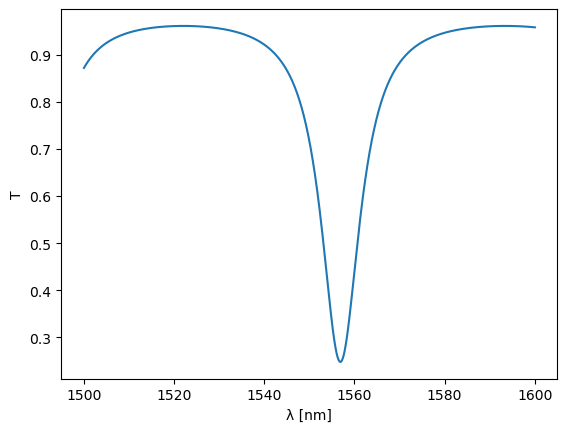

In [4]:
%time detected = all_pass_analytical() # non-jitted evaluation time
all_pass_analytical_jitted = jax.jit(all_pass_analytical)
%time detected = all_pass_analytical_jitted() # time to jit
%time detected = all_pass_analytical_jitted() # evaluation time after jitting

plt.plot(wl * 1e3, detected)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.show()

## Scatter Dictionaries

In [5]:
all_pass_sax, _ = sax.circuit(
    netlist={
        "instances": {
            "dc": {"component": "coupler", "settings": {"coupling": coupling}},
            "top": {
                "component": "straight",
                "settings": {
                    "length": ring_length,
                    "loss": loss,
                    "neff": neff,
                    "ng": ng,
                    "wl0": wl0,
                    "wl": wl,
                },
            },
        },
        "connections": {
            "dc,out1": "top,in0",
            "top,out0": "dc,in1",
        },
        "ports": {
            "in0": "dc,in0",
            "out0": "dc,out0",
        },
    },
    models={
        "coupler": sax.models.coupler,
        "straight": sax.models.straight,
    },
)

CPU times: user 324 ms, sys: 12 ms, total: 336 ms
Wall time: 332 ms
CPU times: user 55 μs, sys: 4 μs, total: 59 μs
Wall time: 61.5 μs
CPU times: user 29 μs, sys: 1 μs, total: 30 μs
Wall time: 33.6 μs


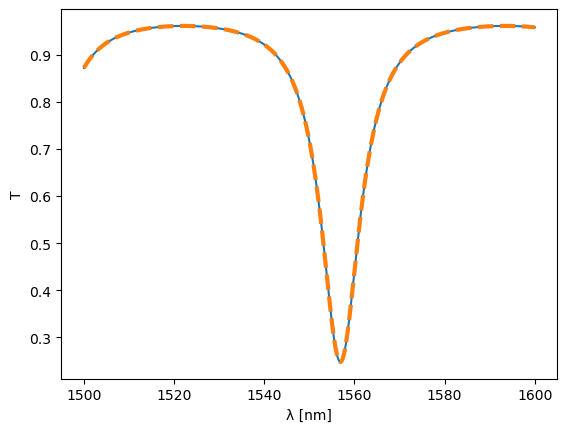

In [6]:
%time detected_sax = all_pass_sax() # non-jitted evaluation time
all_pass_sax_jitted = jax.jit(all_pass_analytical)
%time detected_sax = all_pass_sax_jitted() # time to jit
%time detected_sax = all_pass_sax_jitted() # time after jitting

plt.plot(wl * 1e3, detected, label="analytical")
plt.plot(wl * 1e3, detected_sax, label="sax", ls="--", lw=3)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.show()